In [1]:
import pandas as pd
import numpy as np
import pydotplus
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
from scipy.stats import zscore
from io import StringIO
from efficient_apriori import apriori
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing as spp
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,roc_curve,auc
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from IPython.display import Image
print("libraries imported!")

libraries imported!


In [2]:
dataset = pd.read_csv('HR_comma_sep.csv', 
                         sep= ',')
data = dataset.copy(deep=True)

In [3]:
data.head(10)

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   
5                0.41             0.50               2                   153   
6                0.10             0.77               6                   247   
7                0.92             0.85               5                   259   
8                0.89             1.00               5                   224   
9                0.42             0.53               2                   142   

   time_spend_company  Work_accident  promotion_last_5years departmennt  \
0                   3              0                      0       sales   
1                   6              0                      0       sales   
2                   4              0                      0       sales   
3                   5              0                      0       sales   
4                   3              0                      0       sales   
5                   3              0                      0       sales   
6                   4              0                      0       sales   
7                   5              0                      0       sales   
8                   5              0                      0       sales   
9                   3              0                      0       sales   

   salary  left  
0     low     1  
1  medium     1  
2  medium     1  
3     low     1  
4     low     1  
5     low     1  
6     low     1  
7     low     1  
8     low     1  
9     low     1

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   departmennt            14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## Getting Rid of inconsistencies

In [5]:
#The column "department" is named as "departmennt". so lets rename it to "department".
data.rename(columns={'departmennt': 'department'}, inplace=True)

#Salary has two different names for same category like "low" and "Low", making them same
def salary(row):
    if row['salary'] == 'High' or row['salary'] == 'high':
        return 'high'
    elif row['salary'] == 'Medium' or row['salary'] == 'medium':
        return 'medium'
    else:
        return 'low'
data['salary'] = data.apply(salary,axis=1)

In [6]:
data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  promotion_last_5years department  \
0                   3              0                      0      sales   
1                   6              0                      0      sales   
2                   4              0                      0      sales   
3                   5              0                      0      sales   
4                   3              0                      0      sales   

   salary  left  
0     low     1  
1  medium     1  
2  medium     1  
3     low     1  
4     low     1

In [7]:
data.tail()

satisfaction_level  last_evaluation  number_project  \
14994                0.40             0.57               2   
14995                0.37             0.48               2   
14996                0.37             0.53               2   
14997                0.11             0.96               6   
14998                0.37             0.52               2   

       average_montly_hours  time_spend_company  Work_accident  \
14994                   151                   3              0   
14995                   160                   3              0   
14996                   143                   3              0   
14997                   280                   4              0   
14998                   158                   3              0   

       promotion_last_5years department salary  left  
14994                      0    support    low     1  
14995                      0    support    low     1  
14996                      0    support    low     1  
14997                      0    support    low     1  
14998                      0    support    low     1

# Finding missing values and replacing them by an appropriate strategy.
#### (Back-fill, mode-fill)


In [8]:
data['satisfaction_level'] = data['satisfaction_level'].fillna(data['satisfaction_level'].mode()[0])
data['last_evaluation'] = data['last_evaluation'].fillna(data['last_evaluation'].mode()[0])
data['number_project'] = data['number_project'].fillna(data['number_project'].mode()[0])
data['average_montly_hours'] = data['average_montly_hours'].fillna(int(data['average_montly_hours'].mode()[0]))
data['time_spend_company'] = data['time_spend_company'].fillna(data['time_spend_company'].mode()[0])
data['Work_accident'] = data['Work_accident'].bfill()
data['promotion_last_5years'] = data['promotion_last_5years'].bfill()
data['department'] = data['department'].bfill()
data['salary'] = data['salary'].bfill()
data['left'] = data['left'].bfill()

In [9]:
#In the above table, the salary column contains strings(high, medium, low). 
#We can add another column('salary_numerical') to the table that will return a number if salary is high(3), medium(2) or low(1).
#and check the describe command.

def salary(row):
    if row['salary'] == 'high':
        return 3
    elif row['salary'] == 'medium':
        return 2
    else:
        return 1
    
data['salary_numerical'] = data.apply(salary, axis=1)

data.describe()

satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident  \
count          14999.000000        14999.000000   14999.000000   
mean             201.050337            3.498233       0.144610   
std               49.943099            1.460136       0.351719   
min               96.000000            2.000000       0.000000   
25%              156.000000            3.000000       0.000000   
50%              200.000000            3.000000       0.000000   
75%              245.000000            4.000000       0.000000   
max              310.000000           10.000000       1.000000   

       promotion_last_5years          left  salary_numerical  
count           14999.000000  14999.000000      14999.000000  
mean                0.021268      0.238083          1.594706  
std                 0.144281      0.425924          0.637183  
min                 0.000000      0.000000          1.000000  
25%                 0.000000      0.000000          1.000000  
50%                 0.000000      0.000000          2.000000  
75%                 0.000000      0.000000          2.000000  
max                 1.000000      1.000000          3.000000

In [10]:
#normalizig for better visualization

normalized_average_montly_hours = data['average_montly_hours']/data['average_montly_hours'].mean()
normalized_average_montly_hours = data['average_montly_hours']/data['average_montly_hours'].mean()
normalized_time_spend_company = data['time_spend_company']/data['time_spend_company'].mean()
normalized_number_project = data['number_project']/data['number_project'].mean()

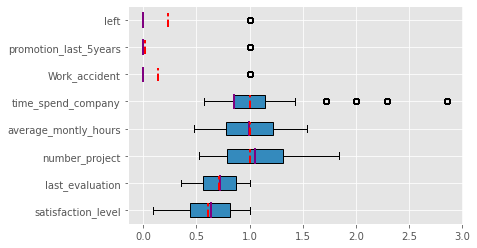

In [11]:
fig, ax = plt.subplots()
ax.boxplot((data['satisfaction_level'],data['last_evaluation'],normalized_number_project,normalized_average_montly_hours,normalized_time_spend_company,data['Work_accident'],data['promotion_last_5years'],data['left']), vert=False, showmeans=True, meanline=True,
           labels=('satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years','left'), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
plt.show()

## Now we find what is correlated in the dataset.

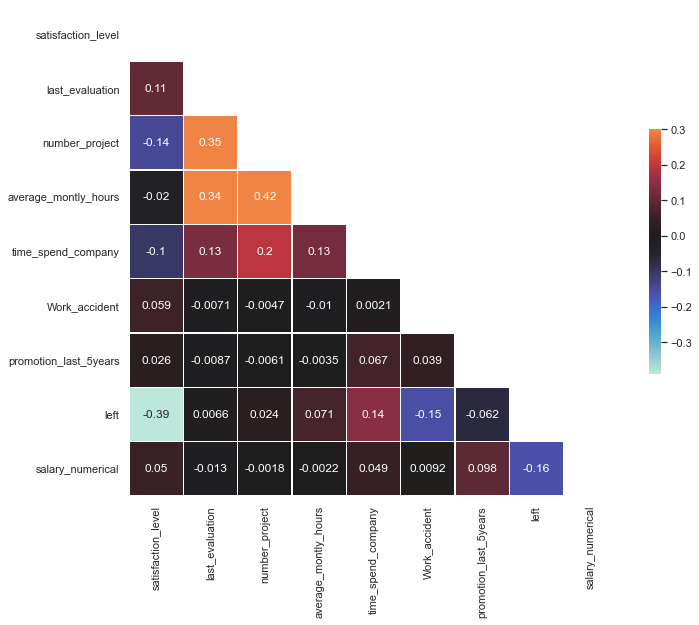

In [12]:
sns.set(style="white")

corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

vf, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### 1:
This correlation matrix tells us that the higher someone is satisfied in their job the less likely they are to leave.
#### 2:
Time spent with the company is positively correlated with leaving, 
#### 3:
suggesting the longer someone works for this organization the more likely they are too leave. 
#### 4:
Another relationship that makes sense is that a higher salary appears to be negatively associated with leaving.
#### 5:
One correlation in the above matrix doesn't quite make sense. 
#### 6:
Having had a work accident is negatively related to leaving the company, which doesn't really make intuitive sense.On the surface this doesn't make a whole lot of sense because you would assume that an employee felt unsafe at an organization that they might want to leave.

In [13]:
left = data.groupby('left')
left.mean()

satisfaction_level  last_evaluation  number_project  \
left                                                        
0               0.666810         0.715473        3.786664   
1               0.440098         0.718113        3.855503   

      average_montly_hours  time_spend_company  Work_accident  \
left                                                            
0               199.060203            3.380032       0.175009   
1               207.419210            3.876505       0.047326   

      promotion_last_5years  salary_numerical  
left                                           
0                  0.026251          1.650945  
1                  0.005321          1.414730

Here you can interpret, Employees who left the company had low satisfaction level, low promotion rate, low salary, and worked more compare to who stayed in the company.

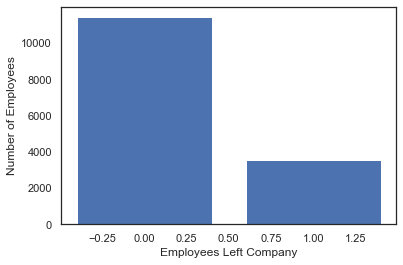

In [14]:
left_count=data.groupby('left').count()
plt.bar(left_count.index.values, left_count['satisfaction_level'])
plt.xlabel('Employees Left Company')
plt.ylabel('Number of Employees')
plt.show()

In [15]:
data.left.value_counts()

0    11428
1     3571
Name: left, dtype: int64

Here, you can see out of 15,000 approx 3,571 were left, and 11,428 stayed. The no of employee left is 23 % of the total employment.

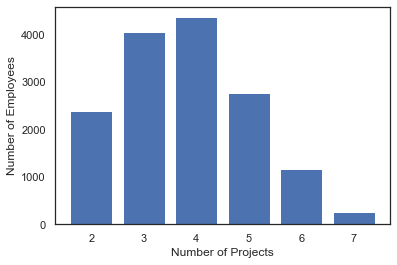

In [16]:
num_projects=data.groupby('number_project').count()
plt.bar(num_projects.index.values, num_projects['satisfaction_level'])
plt.xlabel('Number of Projects')
plt.ylabel('Number of Employees')
plt.show()

Most of the employee is doing the project from 3-5

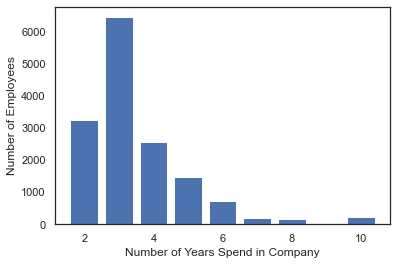

In [17]:
time_spent=data.groupby('time_spend_company').count()
plt.bar(time_spent.index.values, time_spent['satisfaction_level'])
plt.xlabel('Number of Years Spend in Company')
plt.ylabel('Number of Employees')
plt.show()

Most of the employee experience between 2-4 years. Also, there is a massive gap between 3 years and 4 years experienced employee.

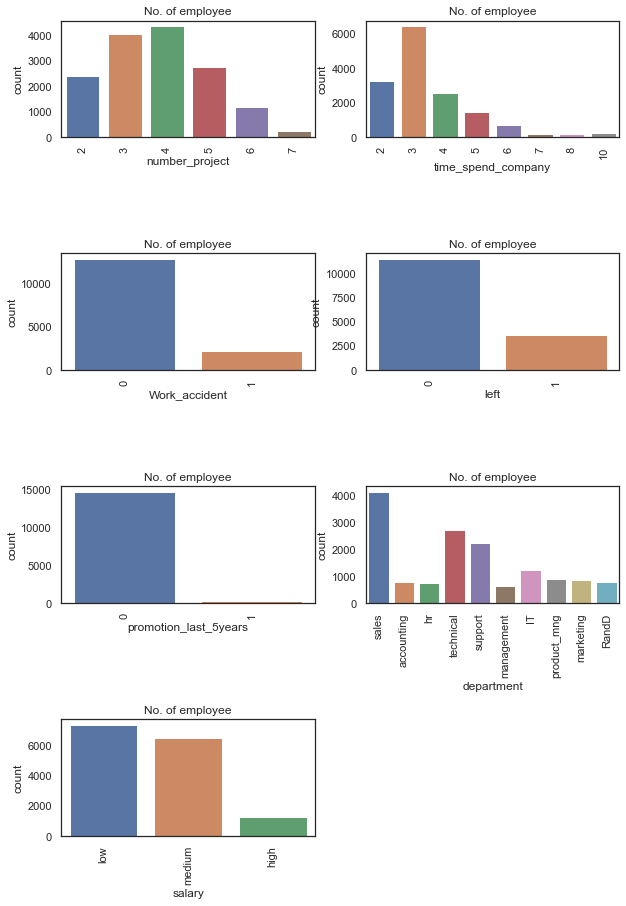

In [18]:
features=['number_project','time_spend_company','Work_accident','left', 'promotion_last_5years','department','salary']
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = data)
    plt.xticks(rotation=90)
    plt.title("No. of employee")

**You can observe the following points in the above visualization:**

**1** Most of the employee is doing the project from 3-5.

**2** There is a huge drop between 3 years and 4 years experienced employee.

**3** The no of employee left is 23 % of the total employment.

**4** A decidedly less number of employee get the promotion in the 
last 5 year.

**5** The sales department is having maximum no.of employee followed by technical and support

**6** Most of the employees are getting salary either medium or low.

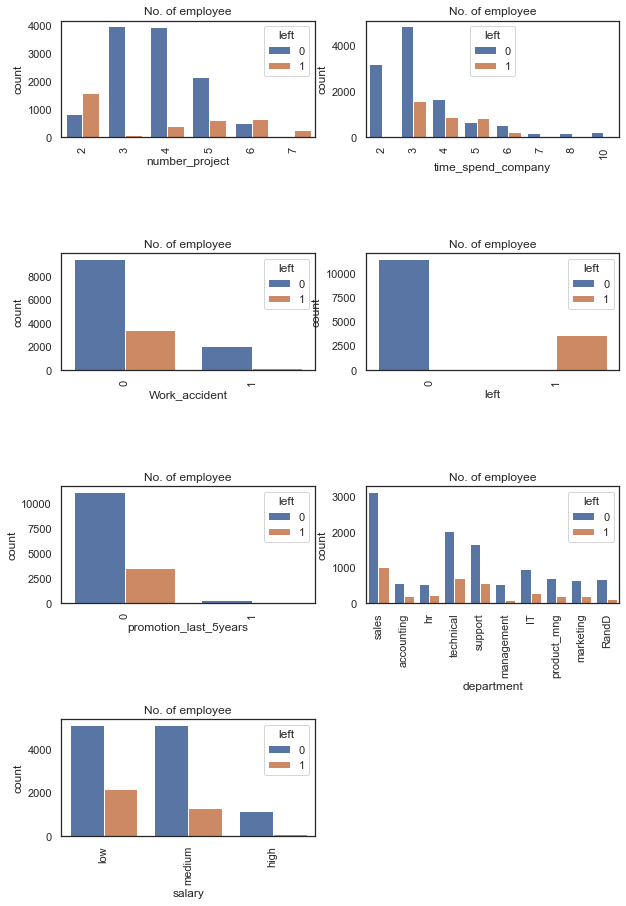

In [19]:
fig=plt.subplots(figsize=(10,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = data, hue='left')
    plt.xticks(rotation=90)
    plt.title("No. of employee")

**You can observe the following points in the above visualization:**

**1** Those employees who have the number of projects more than 5 were left the company.

**2** The employee who had done 6 and 7 projects, left the company it seems to like that they were overloaded with work.

**3** The employee with five-year experience is leaving more because of no promotions in last 5 years and more than 6 years experience are not leaving because of affection with the company.

**4** Those who promotion in last 5 years they didn't leave, i.e., all those left they didn't get the promotion in the previous 5 years.

#### Data Analysis and Visualization Summary:
Following features are most influencing a person to leave the company:

* Promotions: Employees are far more likely to quit their job if they haven't received a promotion in the last 5 years.

* Time with Company: Here, The three-year mark looks like a time to be a crucial point in an employee's career. Most of them quit their job around the three-year mark. Another important point is 6-years point, where the employee is very unlikely to leave.

* Number Of Projects: Employee engagement is another critical factor to influence the employee to leave the company. Employees with 3-5 projects are less likely to leave the company. The employee with less and more number of projects are likely to leave.

* Salary: Most of the employees that quit among the mid or low salary groups.

## What makes people leave the company

### Department and People left

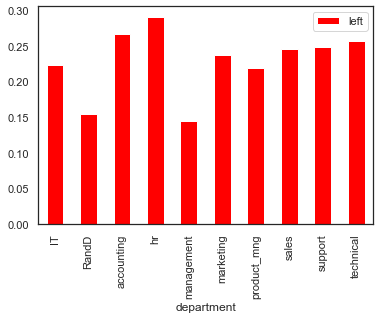

In [20]:
data_department = data.groupby(by='department',as_index=False).mean()
#Pure Count
data_department.plot(kind = "bar", x ='department', y='left', color = 'red')

#### Findings:-
#### 1:
We See that hr, accounting and Technical Departments have more employees who left the company.
#### 2:
However, without knowing the total staffing count at the organization, this variable isn't too helpful.

### Satisfaction & People left

In [21]:
#Creating a new column and assigning qualitative rankings for three(3) Satisfaction levels(High, Medium and Low).
#and adding a new column "Satisfaction" to hold the qualitative rankings.

def satisfaction(row):
    if row['satisfaction_level'] >= .5:
        return 'medium'
    elif .3 <= row['satisfaction_level'] < .5:
        return 'high'
    else:
        return 'low'

data['qualitative_satisfaction'] = data.apply(satisfaction, axis=1)

data_satisfaction = data.groupby(by='qualitative_satisfaction',as_index=False).mean()
data_satisfaction.head()

qualitative_satisfaction  satisfaction_level  last_evaluation  \
0                     high            0.411455         0.573588   
1                      low            0.152213         0.781651   
2                   medium            0.748778         0.740814   

   number_project  average_montly_hours  time_spend_company  Work_accident  \
0        2.703469            161.674375            3.271913       0.096979   
1        5.291272            236.805468            4.288644       0.117245   
2        3.814324            204.656394            3.412154       0.161866   

   promotion_last_5years      left  salary_numerical  
0               0.015666  0.597538          1.515479  
1               0.012093  0.496845          1.538906  
2               0.024386  0.098310          1.625288

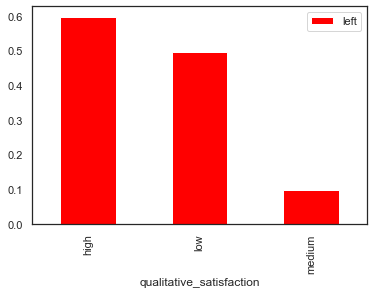

In [22]:
#Pure Count
data_satisfaction.plot(kind = "bar", x ='qualitative_satisfaction', y='left', color = 'red')

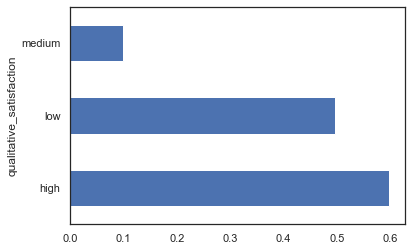

In [23]:
#Percentage or Rate.
data_satisfaction = data.groupby(by=['qualitative_satisfaction'])
left_rate_satisfaction = data_satisfaction['left'].sum() / data_satisfaction['left'].count()
ax = left_rate_satisfaction.plot(kind='barh')

#### Findings:-
#### 1:
It is interesting. Those with high satisfaction levels are more likely to leave based on percentage of those who left, which doesn't make intuitive sense
#### 2:
if we use our three-category breakdown. This chart suggests that those who have medium satisfaction are the least likely to leave.

### Salary and People left

In [24]:
#befor that let's group data by salary
data_salary = data.groupby(by=['salary'],as_index=False).count()
data_salary

salary  satisfaction_level  last_evaluation  number_project  \
0    high                1237             1237            1237   
1     low                7316             7316            7316   
2  medium                6446             6446            6446   

   average_montly_hours  time_spend_company  Work_accident  \
0                  1237                1237           1237   
1                  7316                7316           7316   
2                  6446                6446           6446   

   promotion_last_5years  department  left  salary_numerical  \
0                   1237        1237  1237              1237   
1                   7316        7316  7316              7316   
2                   6446        6446  6446              6446   

   qualitative_satisfaction  
0                      1237  
1                      7316  
2                      6446

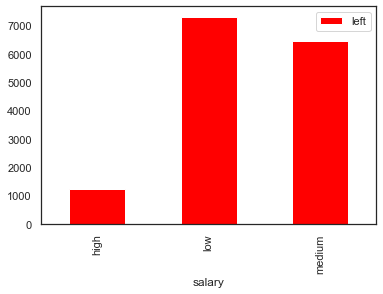

In [25]:
#Pure Count
data_salary.plot(kind = "bar", x ='salary', y='left', color = 'red')

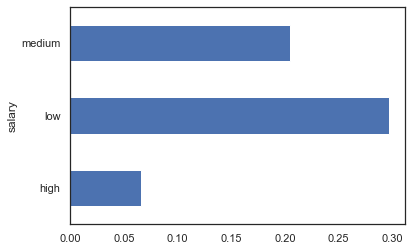

In [26]:
#Percentage or Rate.
data_salary = data.groupby(by=['salary'])
left_rate_salary = data_salary['left'].sum() / data_salary['left'].count()
ax = left_rate_salary.plot(kind='barh')

#### Findings:-
#### 1:
Salary have a linear relationship with leaving, with the more money you earn the less likely you are to leave.

### Collective Effect of Salary and Satisfaction in terms of Leaving the Company

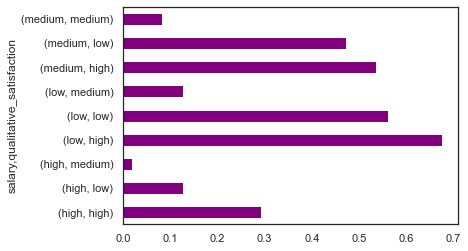

In [27]:
# Set a default value
data_salary_satisfaction = data.groupby(by=['salary','qualitative_satisfaction'])
# data_salary_satisfaction.head()
left_rate_sal_sat = data_salary_satisfaction['left'].sum() / data_salary_satisfaction['left'].count()
ax = left_rate_sal_sat.plot(kind='barh', color='purple')


#### Findings:-
#### 1:
Employees with the highest rate of leaving earns a low salary and reports a medium satisfaction rate.
#### 2:
Aso Employees with the lowest rate of leaving earns the highest salary and reports medium satsifaction.

## Now, let's have a closer look at the satisfaction level variable

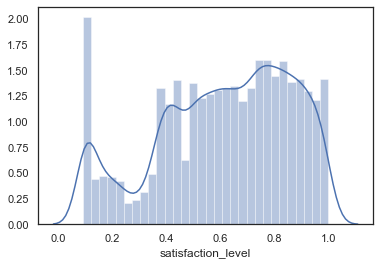

In [28]:
ax = sns.distplot(data['satisfaction_level'])

#### Finding:-
Satisfaction is not normally distributed. 


### Reasons behind higher and lower Satisfaction

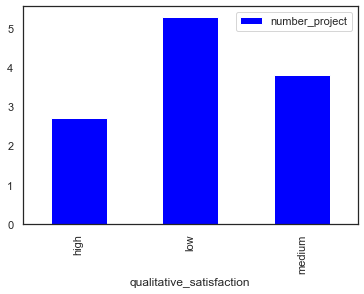

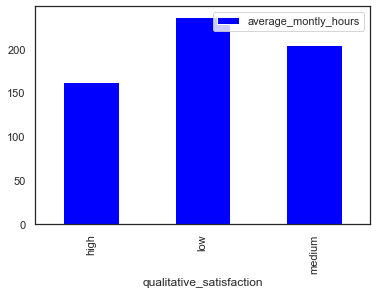

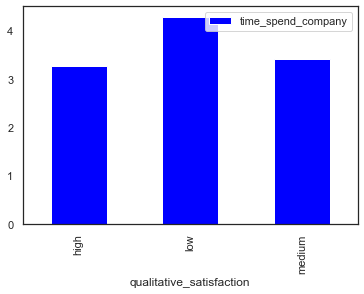

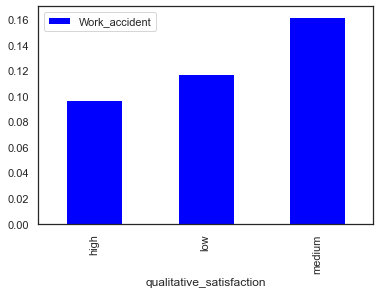

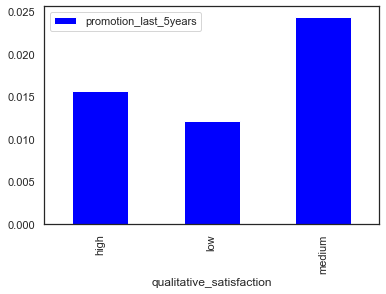

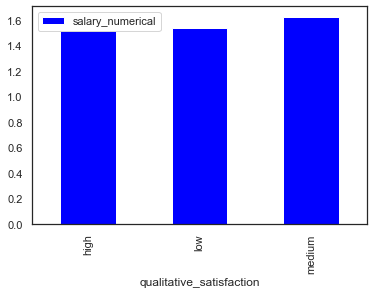

In [29]:
data_satisfaction = data.groupby(by='qualitative_satisfaction',as_index=False).mean()
# Satisfaction & Project Numbers
data_satisfaction.plot(kind = "bar", x ='qualitative_satisfaction', y='number_project', color = 'blue')
# Satisfaction & average_montly_hours
data_satisfaction.plot(kind = "bar", x ='qualitative_satisfaction', y='average_montly_hours', color = 'blue')
# Satisfaction & time_spend_company
data_satisfaction.plot(kind = "bar", x ='qualitative_satisfaction', y='time_spend_company', color = 'blue')
# Satisfaction & Work_accident
data_satisfaction.plot(kind = "bar", x ='qualitative_satisfaction', y='Work_accident', color = 'blue')
# Satisfaction & promotion_last_5years
data_satisfaction.plot(kind = "bar", x ='qualitative_satisfaction', y='promotion_last_5years', color = 'blue')
# Satisfaction & salary_numerical
data_satisfaction.plot(kind = "bar", x ='qualitative_satisfaction', y='salary_numerical', color = 'blue')

#### Findings:-
#### 1:
This shows people with lowest number of projects and lowest number of time spend time monthly have highest satisfaction and people with most number of projects and highest monthly hours tends to loose internal peace.
#### 2:
Total time spent in company does't seem to have much effect on satisfactin, but people who spend 4 or more years tends to have low satisfactio, i.e passing time effects thier satisfaction.
#### 3:
People who have most number of work accidents have medium satisfaction, but less number od work accidents doesn't promise more satisfaction
#### 4:
Similarly promotion in last five years doesn't have linear effect on satisfaction.
#### 5:
Salary doesn't seem to have any effect on satisfaction, as people with high, medium or low satisfaction have same average salary. This is quite strange as because salary is believed to have a major effect on employees satisfaction.


## Cluster Analysis

In [30]:
#data processing
dep_sal_backup = data[['department','salary']]
le = LabelEncoder()
k = le.fit_transform(data['department'])
data['department_numerical'] = k
data.drop([ 'salary', 'department', 'qualitative_satisfaction'], axis=1, inplace=True)
data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  promotion_last_5years  left  \
0                   3              0                      0     1   
1                   6              0                      0     1   
2                   4              0                      0     1   
3                   5              0                      0     1   
4                   3              0                      0     1   

   salary_numerical  department_numerical  
0                 1                     7  
1                 2                     7  
2                 2                     7  
3                 1                     7  
4                 1                     7

### KMeans

In [31]:
X = data.to_numpy()
# Normalized numpy array, used later in the visualization step

In [32]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 0)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

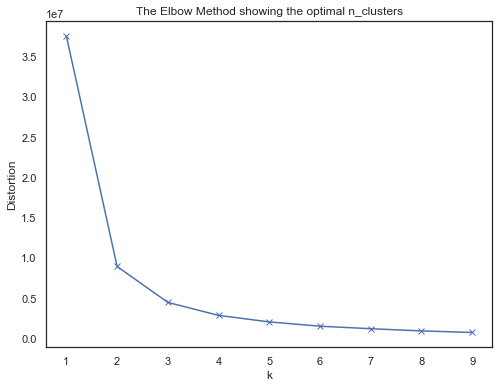

In [33]:
plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal n_clusters')
plt.show()

#### Findings:

Elbow method suggests optimal number of clusters is 3

In [34]:
# Initialize
kmeans = KMeans(n_clusters=3, random_state = 0)
# Fit
kmeans.fit(X)
# Print labels
print(kmeans.labels_)


[2 1 1 ... 2 1 2]


In [35]:
kmeans_data = data.copy(deep = True)
kmeans_data['labels'] = kmeans.labels_
kmeans_data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  promotion_last_5years  left  \
0                   3              0                      0     1   
1                   6              0                      0     1   
2                   4              0                      0     1   
3                   5              0                      0     1   
4                   3              0                      0     1   

   salary_numerical  department_numerical  labels  
0                 1                     7       2  
1                 2                     7       1  
2                 2                     7       1  
3                 1                     7       0  
4                 1                     7       2

<class 'pandas.core.indexes.base.Index'>


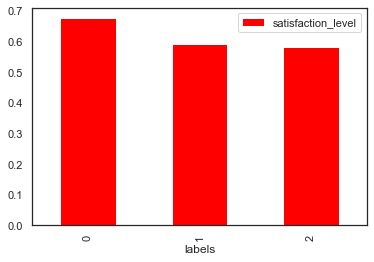

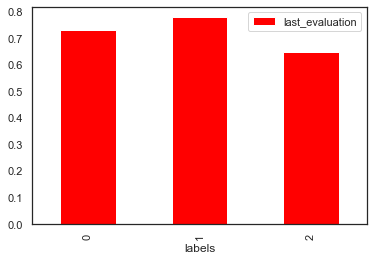

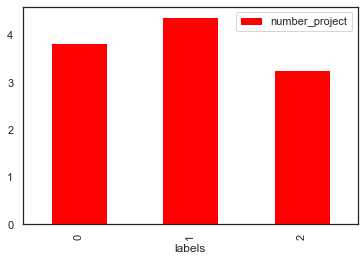

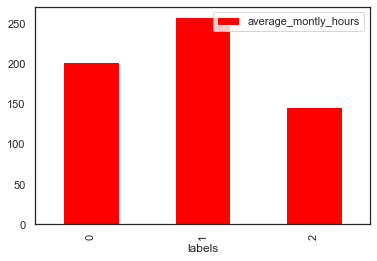

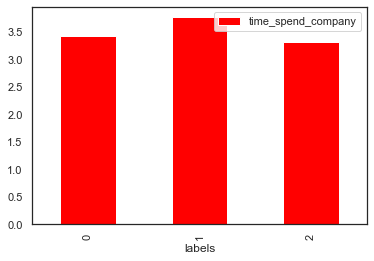

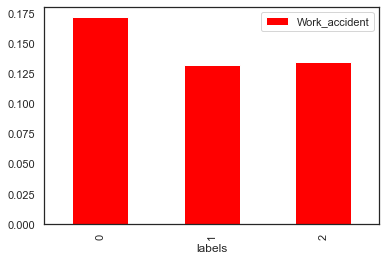

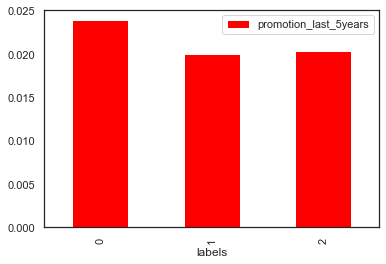

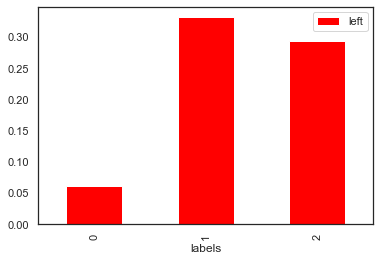

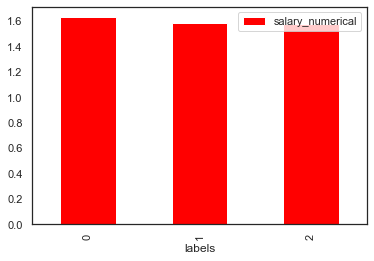

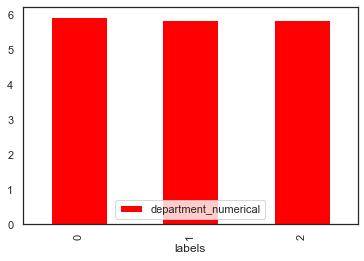

In [36]:
kmeans_columns = kmeans_data.columns  
print(type(kmeans_columns))
# remove labels
kmeans_columns = kmeans_columns.delete(10)
# print(kmeans_columns)
for col in kmeans_columns:
    data_age = kmeans_data.groupby(by='labels',as_index=False).mean()
    data_age.plot(kind = "bar", x ='labels', y=col, color = 'red')

#### Characteristics for each cluster  
0. Lowest rating at Last Evaluation, Least number of projects, Lowest Average Monthly hours
1. Highest rating at Last Evaluation , Most number of projects, Highest Average Monthly Hours,  **Highest left rate**
2. Highest Satisfaction, Most work accidents, Highest promotion,  **Lowest left rate**

All three clusters have almost equal salary, department distribution, time spend company

## Outlier Analysis

Outlier detection can be done on satisfaction_level, last_evaluation, number_project, average_montly_hours, time_spend_company because the rest of the attributes are boolean or categorical

In [37]:
outlier_data = data.drop([ 'Work_accident', 'promotion_last_5years', 'left', 'salary_numerical', 'department_numerical'], axis='columns')
outlier_data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  
0                   3  
1                   6  
2                   4  
3                   5  
4                   3

#### BoxPlot

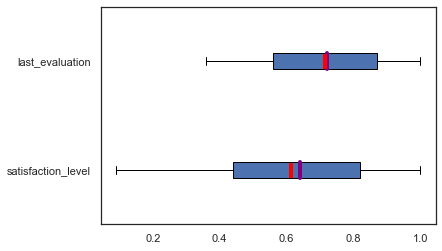

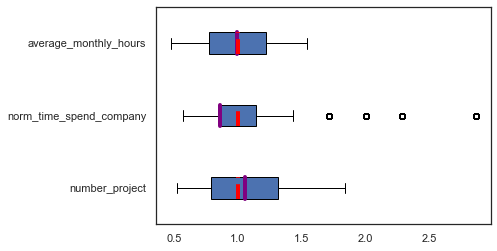

In [38]:
fig, ax = plt.subplots()
ax.boxplot((outlier_data['satisfaction_level'], outlier_data['last_evaluation']), vert=False, showmeans=True, meanline=True,
           labels=('satisfaction_level','last_evaluation'), patch_artist=True,
           medianprops={'linewidth': 4, 'color': 'purple'},
           meanprops={'linewidth': 4, 'color': 'red'})
plt.show()
norm_average_montly_hours = outlier_data['average_montly_hours']/outlier_data['average_montly_hours'].mean()
norm_number_project = outlier_data['number_project']/outlier_data['number_project'].mean()
norm_time_spend_company = outlier_data['time_spend_company']/outlier_data['time_spend_company'].mean()
fig, ax = plt.subplots()
ax.boxplot((norm_number_project,norm_time_spend_company ,norm_average_montly_hours ), vert=False, showmeans=True, meanline=True,
           labels=('number_project','norm_time_spend_company','average_monthly_hours'), patch_artist=True,
           medianprops={'linewidth': 4, 'color': 'purple'},
           meanprops={'linewidth': 4, 'color': 'red'})
plt.show()


#### Findings:

#### ZScore

In [39]:
zscore_data = data.drop([ 'Work_accident', 'promotion_last_5years', 'left', 'salary_numerical', 'department_numerical'], axis='columns')
zscore_data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  
0                   3  
1                   6  
2                   4  
3                   5  
4                   3

In [40]:
score = np.abs(zscore(zscore_data))
threshold = 3
zoutliers = np.where(score > threshold)
# type(outliers)
zoutliers_in_dataset = pd.DataFrame(zoutliers).transpose()
zoutliers_in_dataset

0  1
0    11007  4
1    11008  4
2    11009  4
3    11010  4
4    11011  4
..     ... ..
371  14205  4
372  14206  4
373  14207  4
374  14208  4
375  14209  4

[376 rows x 2 columns]

Each row refrences to a particular datapoint in **zscore_data**. The first element contains the row number and second element has column number, which mean zscore_data[11007][4] have a Z-score higher than 3.

#### Findings:

### IQR

In [41]:
iqr_data = data.drop([ 'Work_accident', 'promotion_last_5years', 'left', 'salary_numerical', 'department_numerical'], axis='columns')
iqr_data.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  
0                   3  
1                   6  
2                   4  
3                   5  
4                   3

In [42]:
for col in iqr_data.columns:
    Q1, Q3 = np.percentile(iqr_data[col], 25), np.percentile(iqr_data[col], 75)
    IQR, k = (Q3 - Q1), 3
    lower_Outlier, higher_Outlier = Q1 - (k * IQR), Q3 + (k * IQR) 
    # identify outliers
    iqr_outliers = [j for j in iqr_data[col] if j < lower_Outlier or j > higher_Outlier]
    print("\n" + col + "\n")
    print(iqr_outliers)


satisfaction_level

[]

last_evaluation

[]

number_project

[]

average_montly_hours

[]

time_spend_company

[8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8,

#### Findings

## Prediction Algorithms (which employ will leave)

In [43]:
X=data.drop(['left'],axis=1)
Y=data['left']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,)

In [44]:
features = list(X_test.columns)
X_test

satisfaction_level  last_evaluation  number_project  \
13481                0.16             0.93               5   
12664                0.10             0.77               5   
9232                 0.88             0.50               3   
3444                 0.96             0.75               5   
4393                 0.94             0.47               5   
...                   ...              ...             ...   
10848                0.83             0.86               4   
13898                0.71             0.78               4   
3988                 0.72             0.51               3   
5915                 0.91             0.57               3   
5321                 0.83             0.61               5   

       average_montly_hours  time_spend_company  Work_accident  \
13481                   210                   7              0   
12664                   276                   4              0   
9232                    206                   2              0   
3444                    176                   4              0   
4393                    131                   6              0   
...                     ...                 ...            ...   
10848                    98                   4              0   
13898                   227                   2              0   
3988                    146                   2              1   
5915                    158                   3              0   
5321                    246                   3              0   

       promotion_last_5years  salary_numerical  department_numerical  
13481                      1                 2                     4  
12664                      0                 1                     8  
9232                       0                 2                     1  
3444                       0                 1                     7  
4393                       0                 2                     9  
...                      ...               ...                   ...  
10848                      0                 1                     7  
13898                      0                 1                     8  
3988                       0                 1                     7  
5915                       0                 1                     9  
5321                       0                 2                     8  

[4500 rows x 9 columns]

In [45]:
Y_test

13481    0
12664    1
9232     0
3444     0
4393     0
        ..
10848    0
13898    0
3988     0
5915     0
5321     0
Name: left, Length: 4500, dtype: int64

### Logistical Regrassion

In [46]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 400)
lr.fit(X_train, Y_train)
predict = lr.predict(X_train)
print("Logistic Regression Training Score is",lr.score(X_train,Y_train))
print("Logistic Regression Testing Score is",lr.score(X_test,Y_test))

Logistic Regression Training Score is 0.7905514810934374
Logistic Regression Testing Score is 0.7953333333333333


In [47]:
accuracy_lr = lr.score(X_test,Y_test)*100
print("Accuracy of Logistic Regression is ",accuracy_lr)

Accuracy of Logistic Regression is  79.53333333333333


In [48]:
for col,value in zip(data[features].columns,lr.coef_[0]):
    print(col,"*",value,"+")
print(lr.intercept_[0])

satisfaction_level * -4.011294686307858 +
last_evaluation * 0.6276738724356047 +
number_project * -0.3155459632341092 +
average_montly_hours * 0.004516103912669045 +
time_spend_company * 0.2661973976727499 +
Work_accident * -1.5674158921110983 +
promotion_last_5years * -1.4683386138815178 +
salary_numerical * -0.6753455426169653 +
department_numerical * 0.03250113948178719 +
0.9543423557433329


In [49]:
print("Confusion Matrix for logistic Regression")
print(confusion_matrix(Y_test, lr.predict(X_test)))

Confusion Matrix for logistic Regression
[[3184  249]
 [ 672  395]]


In [50]:
print("Classification Report for Logistic Regression")
print(classification_report(Y_test, lr.predict(X_test)))

Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      3433
           1       0.61      0.37      0.46      1067

    accuracy                           0.80      4500
   macro avg       0.72      0.65      0.67      4500
weighted avg       0.78      0.80      0.78      4500



As observed our Logistic Regression has an accuracy of approx 78% for its predictions and on first glance this might seem to be a pretty good performing model. But,this model has a lower Specificity.

In [51]:
# Compute ROC curve and ROC area for each class
y_score = lr.decision_function(data[features])
n_classes =2
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(data['left'], y_score)
roc_auc = auc(fpr, tpr)

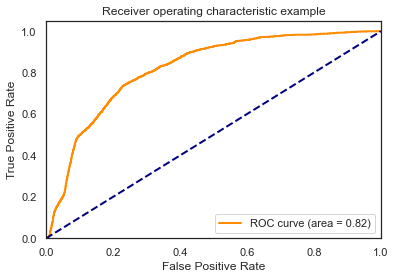

In [52]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw,\
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Findings:**

###  DT

In [53]:
dt=DecisionTreeClassifier(criterion = 'entropy')

dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [54]:
prediction_dt=dt.predict(X_test)
accuracy_dt=accuracy_score(Y_test,prediction_dt)*100
print('Accuracy = ' + str(accuracy_dt))
prediction_dt

Accuracy = 97.53333333333333


array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [55]:
Y_test

13481    0
12664    1
9232     0
3444     0
4393     0
        ..
10848    0
13898    0
3988     0
5915     0
5321     0
Name: left, Length: 4500, dtype: int64

In [56]:
print("Confusion Matrix for Decision Tree")
print(confusion_matrix(Y_test, prediction_dt))

Confusion Matrix for Decision Tree
[[3372   61]
 [  50 1017]]


In [57]:
print("Classification Report for Decision Tree")
print(classification_report(Y_test, prediction_dt))

Classification Report for Decision Tree
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3433
           1       0.94      0.95      0.95      1067

    accuracy                           0.98      4500
   macro avg       0.96      0.97      0.97      4500
weighted avg       0.98      0.98      0.98      4500



In [58]:
#Decision Tree Plot
export_graphviz(dt,feature_names=features, out_file="dtree.dot",
               filled = True, rounded = True,
               special_characters = True)

In [59]:

dot_data = StringIO()
export_graphviz(dt, feature_names = features, out_file=dot_data,
               filled = True, rounded = True,
               special_characters= True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

#### Feature Importance

In [60]:
feature_importance=pd.DataFrame(dt.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values('Importance',ascending=False)
feature_importance

Importance
satisfaction_level       0.430498
time_spend_company       0.205259
last_evaluation          0.142603
average_montly_hours     0.103868
number_project           0.092846
department_numerical     0.013946
salary_numerical         0.008674
Work_accident            0.001954
promotion_last_5years    0.000351

In [61]:
#checkin our model for anyother data
catagory = ['Employe will stay', 'Employ will leave']
custom_dt = [[10,200,4,0,0, 0.80, 0.96, 2, 4]]
catagory[int(dt.predict(custom_dt))]

'Employe will stay'

### KNN

In [62]:
sc=StandardScaler().fit(X_train)
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

In [63]:
X_train_std

array([[ 0.38932548, -1.60426742, -1.45758472, ..., -0.148322  ,
        -0.93859253,  0.3859842 ],
       [ 0.26807222,  0.44320421,  0.17153989, ..., -0.148322  ,
        -0.93859253, -0.31561693],
       [ 1.44018708, -0.96077634,  0.98610219, ..., -0.148322  ,
         2.19024792,  0.3859842 ],
       ...,
       [-0.66153611, -1.37027066, -1.45758472, ..., -0.148322  ,
        -0.93859253,  1.08758532],
       [-0.4998651 ,  0.44320421,  0.17153989, ..., -0.148322  ,
         2.19024792,  0.73678476],
       [ 0.51057874,  1.43769044,  0.17153989, ..., -0.148322  ,
        -0.93859253,  1.08758532]])

In [64]:
k_range=range(1,26)
scores={}
scores_list=[]


for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_std,Y_train)
    prediction_knn=knn.predict(X_test_std)
    scores[k]=accuracy_score(Y_test,prediction_knn)*100
    scores_list.append(accuracy_score(Y_test,prediction_knn))


In [65]:
scores

{1: 96.91111111111111,
 2: 96.55555555555554,
 3: 95.86666666666666,
 4: 96.0,
 5: 95.57777777777777,
 6: 95.97777777777777,
 7: 95.66666666666667,
 8: 95.71111111111111,
 9: 95.51111111111112,
 10: 95.62222222222222,
 11: 95.39999999999999,
 12: 95.44444444444444,
 13: 95.19999999999999,
 14: 95.11111111111111,
 15: 94.93333333333334,
 16: 95.06666666666666,
 17: 94.73333333333333,
 18: 94.82222222222222,
 19: 94.71111111111111,
 20: 94.73333333333333,
 21: 94.55555555555556,
 22: 94.57777777777778,
 23: 94.46666666666667,
 24: 94.55555555555556,
 25: 94.39999999999999}

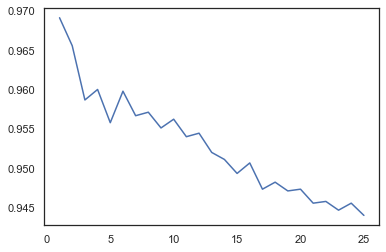

In [66]:
plt.plot(k_range,scores_list)

In [67]:
#using n_neighbors = 1, as it has the highest accuracy
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_std,Y_train)
prediction_knn=knn.predict(X_test_std)
accuracy_knn=accuracy_score(Y_test,prediction_knn)*100
print('Accuracy = ' + str(accuracy_knn))
prediction_knn

Accuracy = 96.91111111111111


array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [68]:
Y_test

13481    0
12664    1
9232     0
3444     0
4393     0
        ..
10848    0
13898    0
3988     0
5915     0
5321     0
Name: left, Length: 4500, dtype: int64

In [69]:
#checkin our model for anyother data
X_knn=np.array([[20,500,10,6,0,0.10,0.30,1,8]])
X_knn_std=sc.transform(X_knn)
X_knn_prediction=knn.predict(X_knn_std)
catagory[X_knn_prediction[0]]

'Employe will stay'

### RANDOM FOREST

In [70]:
rf = RandomForestClassifier(n_estimators=35,criterion="entropy")
rf.fit(X_train,Y_train)
pred_rf = rf.predict(X_test)
print("Training accuracy for Random Forest is",rf.score(X_train,Y_train)*100)
print("Testing accuracy for Random Forest is",rf.score(X_test,Y_test)*100)
accuracy_rf = rf.score(X_test,Y_test)*100

Training accuracy for Random Forest is 99.98095056672064
Testing accuracy for Random Forest is 98.6888888888889


In [71]:
print("Confusion Matrix of Random Forest \n",confusion_matrix(Y_test,pred_rf))

Confusion Matrix of Random Forest 
 [[3421   12]
 [  47 1020]]


In [72]:
print("Classification report for Random Forest")
print(classification_report(Y_test,pred_rf))

Classification report for Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3433
           1       0.99      0.96      0.97      1067

    accuracy                           0.99      4500
   macro avg       0.99      0.98      0.98      4500
weighted avg       0.99      0.99      0.99      4500



#### Feature Importance according to Random Forest

In [73]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = features,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

importance
satisfaction_level       0.322432
time_spend_company       0.220783
average_montly_hours     0.149466
last_evaluation          0.135482
number_project           0.134283
department_numerical     0.018297
salary_numerical         0.012050
Work_accident            0.006350
promotion_last_5years    0.000856

Clearly some features like satisfaction_level, time_spend_company has a higher impact on the retention of the employees. People having a higher satisfaction are more likely to stay in the organization.

### Accuracy Comparison DT vs KNN vs Logistical Regression vs Random Forest

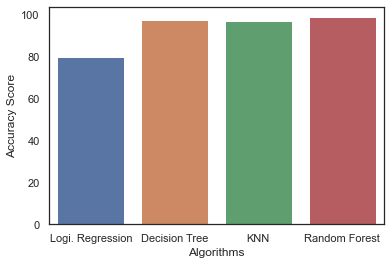

In [74]:
algorithms=['Logi. Regression', 'Decision Tree','KNN', 'Random Forest']
scores=[accuracy_lr, accuracy_dt,accuracy_knn,  accuracy_rf]
plt.xlabel("Algorithms")
plt.ylabel("Accuracy Score")
sns.barplot(algorithms,scores)
plt.show()

## Finding Interesting Patterns

### Apriori

In [75]:
def data_generator(filename):
  """
  Data generator, needs to return a generator to be called several times.
  Use this approach if data is too large to fit in memory. If not use a list.
  """
  def data_gen():
    with open(filename) as file:
      for line in file:
        yield tuple(k.strip() for k in line.split(','))      

  return data_gen

transactions = data_generator('HR_comma_sep.csv')
itemsets, rules = apriori(transactions, min_support=0.3, min_confidence=0.3)
rules

[{1} -> {0},
 {0} -> {1},
 {2} -> {0},
 {0} -> {2},
 {3} -> {0},
 {0} -> {3},
 {low} -> {0},
 {0} -> {low},
 {medium} -> {0},
 {0} -> {medium},
 {4} -> {0},
 {0} -> {4}]

In [76]:
itemsets

{1: {('2',): 5408,
  ('low',): 7316,
  ('3',): 8716,
  ('0',): 14995,
  ('1',): 5983,
  ('medium',): 6446,
  ('4',): 6345},
 2: {('0', '1'): 5979,
  ('0', '2'): 5405,
  ('0', '3'): 8713,
  ('0', 'low'): 7313,
  ('0', 'medium'): 6445,
  ('0', '4'): 6344}}

## PCA Analysis

In [77]:
pca = PCA(n_components = 2)

In [78]:
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [79]:
pca.explained_variance_ratio_

array([0.99505374, 0.00328353])

In [80]:
pca.explained_variance_

array([2494.61707963,    8.23187396])

In [81]:
pca.get_covariance

<bound method _BasePCA.get_covariance of PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)>

In [82]:
pca.mean_

array([6.12833522e-01, 7.16101740e-01, 3.80305354e+00, 2.01050337e+02,
       3.49823322e+00, 1.44609641e-01, 2.12680845e-02, 2.38082539e-01,
       1.59470631e+00, 5.87052470e+00])

In [83]:
pca.score_samples(data)

array([-14.88019135, -18.41685095, -19.42760601, ..., -14.9821359 ,
       -16.0049539 , -15.08192061])

In [84]:
pca.singular_values_

array([6116.72027809,  351.3710939 ])

In [85]:
pca.get_precision

<bound method _BasePCA.get_precision of PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)>

Principal Component Analysis is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

## Naive Bayes Classifier

It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of particular feature in a class is unrelated to the presence of any other feature. The model was trained using the training datasets generated previously ie., X_train and Y_train with an accuracy of 79.89% (approximately) while accuracy at testing was 80.13% (approximately). Guassian is used in classification and assumes that feature follow a normal distribution due to which the accuracy is not at par with other methods. It can be observed from the figure that 2111 points were mislabeled out of 104099 which makes up 14.07% (approximately) of the dataset.

In [86]:
gnb = GaussianNB()

In [87]:
gnb.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [88]:
pred_gnb = gnb.predict(X_train)
gnb.score(X_train, Y_train)

0.786932088770359

In [89]:
accuracy_gnb = gnb.score(X_test, Y_test)
accuracy_gnb

0.7944444444444444

In [90]:
gnb.predict_proba(X_test)

array([[1.00000000e+00, 1.97867215e-34],
       [1.94385259e-02, 9.80561474e-01],
       [9.37526631e-01, 6.24733694e-02],
       ...,
       [9.99938127e-01, 6.18731158e-05],
       [7.11320728e-01, 2.88679272e-01],
       [7.04988224e-01, 2.95011776e-01]])

In [91]:
print("Number of mislabeled points out of total %d points : %d" %(X_train.shape[0], (Y_train != pred_gnb).sum()))

Number of mislabeled points out of total 10499 points : 2237


In [92]:
print("Accuracy = ", accuracy_gnb*100)

Accuracy =  79.44444444444444
